## A simple Autoencoder to be trained on GPU/CPU 

### Aimed at compressing Stokes I (for now) for synthesized observed photospheric spectral lines 

### various training and validation sets available at: 

https://drive.google.com/drive/folders/1SO4FyyX_X878FAcU7k1zD6AkOvFyWMH4?usp=sharing

In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# We are going to make a dense autoencoder here:


class dense_ae(nn.Module):
    def __init__(self, inputsize, bottleneck):
        super(dense_ae, self).__init__()
        self.linear1 = nn.Linear(inputsize,60)
        self.linear2 = nn.Linear(60,30)
        #self.linear3 = nn.Linear(80,40)
        #self.linear4 = nn.Linear(40,20)
        self.linear5 = nn.Linear(30, bottleneck)
        
        self.linear6 = nn.Linear(bottleneck,30)
        self.linear7 = nn.Linear(30,60)
        #self.linear8 = nn.Linear(40,80)
        #self.linear9 = nn.Linear(80,80)
        self.linear10 = nn.Linear(60,inputsize)
        
        self.activation = nn.ReLU()
        self.activationS = nn.Sigmoid()
        
        self.bn_1i = nn.BatchNorm1d(60)
        self.bn_2i = nn.BatchNorm1d(30)
        self.bn_3i = nn.BatchNorm1d(bottleneck)
        self.bn_bottleneck = nn.BatchNorm1d(bottleneck)
        
        self.bn_1o = nn.BatchNorm1d(30)
        self.bn_2o = nn.BatchNorm1d(60)
        #self.bn_3o = nn.BatchNorm1d(bottleneck)
        
        self.dropout05 = nn.Dropout(0.5)
        
        
        
    def encode(self,x):
        
        out = self.linear1(x)
        out = self.activation(out)
        
        out = self.linear2(out)
        out = self.activation(out)
        
        out = self.linear5(out)
        out = self.activationS(out)
        
        return out;
        
    def decode(self,x):
        
        out = self.linear6(x)
        out = self.activation(out)
        
        out = self.linear7(out)
        out = self.activation(out)
        
        out = self.linear10(out)
        out = self.activationS(out)
        
        return out;
        
    def forward(self, x):
        
        compressed = self.encode(x);
        restored   = self.decode(compressed);
        
        return restored;
    
def make_model(cudaoption, inputsize, bottleneck):
    
    model = dense_ae(inputsize, bottleneck)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

def model_encode(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.encode(inputdata)
    
    output = output.to("cpu")
    return output

def model_decode(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.decode(inputdata)
    
    output = output.to("cpu")
    return output

## Let's make a function to train:

def compilefit(model, data_in, data_out, data_val_in, data_val_out, nepochs, criterion, cudaoption, lri, output_interval, batch, weight_decayi, w):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri, weight_decay = weight_decayi)
    loss_fn = nn.MSELoss()
    loss_val_fn = nn.MSELoss()
    
    if cudaoption:
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        data_val_in = data_val_in.to(device)
        data_val_out = data_val_out.to(device)
        
        if (w):
            w = w.to(device)
        
        
    performance = np.zeros([2,nepochs])
    
    #N_data = len(data[:,0])
    #N_batches = N_data // batch
            
    for i in range(0,nepochs):
        
        #indices = np.arange(N_data)
        #indices = np.random.permutation(indices)
        
        #for j in range(0, N_batches):
            
        #data_batch = data[j*batch:(j+1)*batch,:]
        
        
        optimizer.zero_grad()
        out = model.forward(data_in)
        #loss = loss_fn(data_out / w[None,:],out / w[None,:])
        loss = loss_fn(data_out, out)
        loss.backward()
        optimizer.step()
        performance[0,i] = loss.item()
        
        # Validation:
        out_val = model.forward(data_val_in)
        #loss_val = loss_val_fn(out_val / w[None,:], data_val_out / w[None,:])
        loss_val = loss_val_fn(out_val, data_val_out)
        performance[1,i] = loss_val.item()
        
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - residual std : {np.sqrt(loss.item()):.6f} - val std : {np.sqrt(loss_val.item()):.6f}')
    return performance

In [3]:
# test for GPU:

cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0


In [33]:
ae_model = make_model(cudaoption, 102, 6)

[INFO] Cuda model: NVIDIA GeForce RTX 2060 with Max-Q Design
[INFO] Parameters in GPU: True


### Ok, creating the model and making sure GPU works is done, now let's see what happens with data.

In [170]:
from astropy.io import fits 

In [171]:
data = fits.open("C:/Data/Hinode_ML_compression/qs_ph_disk_center_1_1_tau.fits")[0].data

In [172]:
print (data.shape)
data = data.transpose(0,2,3,1)
print (data.shape)

(11, 71, 768, 768)
(11, 768, 768, 71)


In [173]:
#del(stokes)

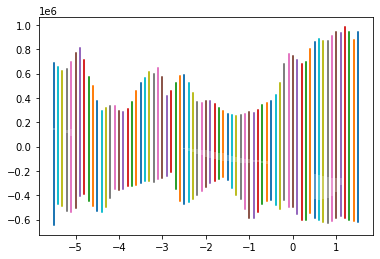

In [174]:
plt.plot(data[0,0], data[5,0])

In [175]:
data = data.reshape(11,768 * 768, 71)

In [176]:
Nval = 150000
indices = (np.arange(Nval).astype('int'))
import random

random_sample  = random.sample(indices.tolist(),Nval)
data = data[:,random_sample,:]

print(data.shape)

(11, 150000, 71)


In [177]:
params = [1,5]
data = data[params,:,:]

In [178]:
print (data.shape)


(2, 150000, 71)


In [179]:
dmax = np.amax(data, axis=(1,2))
dmin = np.amin(data, axis=(1,2))
print (dmax, dmin)

[  10991.59940038 1532599.99841862] [    2684.79135309 -1448807.5302869 ]


In [180]:
data[:,:,:] = (data[:,:,:] - dmin[:, None, None]) / (dmax[:, None, None] - dmin [:, None, None])
data = data.transpose(1,0,2)


In [181]:
data = data[:,:,5:-15]
data.shape

(150000, 2, 51)

In [182]:
data = data.reshape(150000, 2*51)

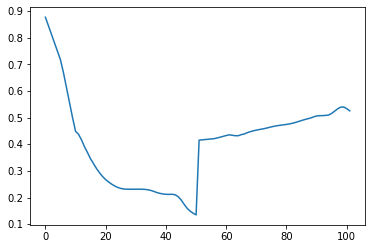

In [183]:
plt.plot(data[190])

In [184]:
#data_torch = torch.from_numpy(data_norm.astype('float32'))
data = torch.from_numpy(data.astype('float32'))

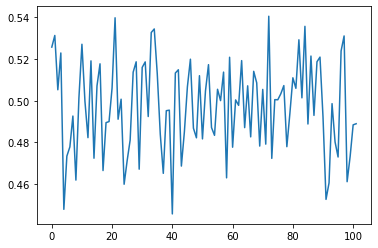

In [185]:
test_output = model_predict(ae_model,data[:10],cudaoption)
test_output.shape
plt.plot(test_output[0].detach().numpy())

In [186]:
# Create model again as the above was just testing:
ae_model = make_model(cudaoption, 102, 6)

[INFO] Cuda model: NVIDIA GeForce RTX 2060 with Max-Q Design
[INFO] Parameters in GPU: True


In [187]:
#convergence = compilefit(ae_model, data_torch, 1000, 0, cudaoption, 1E-2, 200, 256)
#convergence = compilefit(ae_model, data_torch, 5000, 0, cudaoption, 5E-3, 200, 256)
#convergence = compilefit(ae_model, data_norm_in, data_norm_out, 10000, 0, cudaoption, 2E-3, 200, 256)
convergence = compilefit(ae_model, data, data, data, data, 50000, 0, cudaoption, 5E-3, 200, 256, 0, 0)

#convergence = compilefit(ae_model, data_norm_in, data_norm_out, 50000, 0, cudaoption, 5E-4, 200, 256, 1E-6)

 It : 200 - residual std : 0.031791 - val std : 0.031775
 It : 400 - residual std : 0.029643 - val std : 0.029570
 It : 600 - residual std : 0.026643 - val std : 0.026627
 It : 800 - residual std : 0.026332 - val std : 0.027912
 It : 1000 - residual std : 0.024835 - val std : 0.024810
 It : 1200 - residual std : 0.023323 - val std : 0.023323
 It : 1400 - residual std : 0.022957 - val std : 0.022959
 It : 1600 - residual std : 0.022314 - val std : 0.022137
 It : 1800 - residual std : 0.020585 - val std : 0.020580
 It : 2000 - residual std : 0.020148 - val std : 0.020145
 It : 2200 - residual std : 0.020021 - val std : 0.020041
 It : 2400 - residual std : 0.023684 - val std : 0.022463
 It : 2600 - residual std : 0.019781 - val std : 0.019782
 It : 2800 - residual std : 0.020256 - val std : 0.020145
 It : 3000 - residual std : 0.019759 - val std : 0.019729
 It : 3200 - residual std : 0.019662 - val std : 0.019662
 It : 3400 - residual std : 0.019642 - val std : 0.019644
 It : 3600 - resid

 It : 28200 - residual std : 0.014011 - val std : 0.014175
 It : 28400 - residual std : 0.014060 - val std : 0.014143
 It : 28600 - residual std : 0.014325 - val std : 0.014292
 It : 28800 - residual std : 0.014142 - val std : 0.014223
 It : 29000 - residual std : 0.014229 - val std : 0.014336
 It : 29200 - residual std : 0.013954 - val std : 0.013984
 It : 29400 - residual std : 0.014225 - val std : 0.014403
 It : 29600 - residual std : 0.014028 - val std : 0.014166
 It : 29800 - residual std : 0.014007 - val std : 0.014000
 It : 30000 - residual std : 0.015482 - val std : 0.015947
 It : 30200 - residual std : 0.013922 - val std : 0.013921
 It : 30400 - residual std : 0.014207 - val std : 0.014193
 It : 30600 - residual std : 0.013938 - val std : 0.013937
 It : 30800 - residual std : 0.014019 - val std : 0.014082
 It : 31000 - residual std : 0.013948 - val std : 0.013940
 It : 31200 - residual std : 0.013918 - val std : 0.013935
 It : 31400 - residual std : 0.013953 - val std : 0.0139

In [190]:
torch.save(ae_model, 'hinode_encoding_atmos_6.pt')

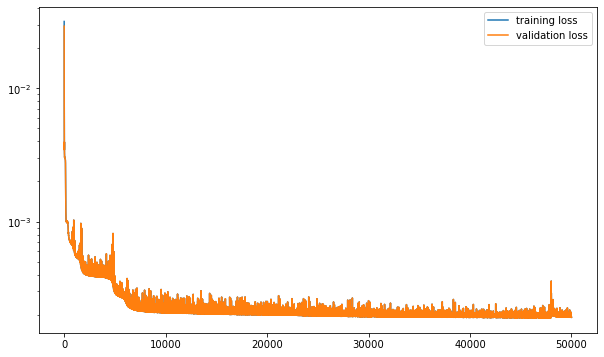

In [191]:
plt.figure(figsize=[10,6])
plt.semilogy(convergence[0],label='training loss') 
plt.semilogy(convergence[1], label = 'validation loss') 
plt.legend()

In [77]:
#ae_model = make_model(cudaoption, 112, 12)
#convergence = compilefit(ae_model, data_norm_in, data_norm_out, 50000, 0, cudaoption, 1E-3, 200, 256, 1E-6)
#convergence = compilefit(ae_model, data_norm_in, data_norm_out, 50000, 0, cudaoption, 5E-4, 200, 256, 1E-6)
#torch.save(ae_model, 'hinode_encoding_10noisy_decay.pt')
#plt.figure(figsize=[10,6])

In [78]:
#plt.figure(figsize=[10,6])
#plt.semilogy(convergence) 

### Here we do some statistical analysis of the "compression"

In [39]:
test_output = model_predict(ae_model,data,cudaoption)

In [40]:
data_reconstructed = test_output.detach().numpy()

In [41]:
data_reconstructed.shape

(150000, 102)

In [43]:
data_reconstructed = data_reconstructed.reshape(150000, 2, 51)

data_reconstructed = data_reconstructed * (dmax [None, :, None] - dmin[None, :, None]) + dmin[None, :, None]

In [47]:
data.shape
data = data.detach().numpy().reshape(-1, 2, 51)

In [51]:
data = data * (dmax [None, :, None] - dmin[None, :, None]) + dmin[None, :, None]

In [52]:
noise = np.mean(data) * 1E-2

residual = (data - data_reconstructed)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 201
print (np.mean(chisq))
print (np.median(chisq))

150000
7806.627183665057
1852.6060052923804


(array([[232., 125., 150., ...,  23.,  17.,  16.],
        [317., 199., 140., ...,  35.,  36.,  29.],
        [449., 205., 186., ...,  38.,  25.,  36.],
        ...,
        [376., 246., 167., ...,  32.,  38.,  30.],
        [312., 214., 161., ...,  38.,  31.,  33.],
        [248., 165., 157., ...,  28.,  27.,  26.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <a list of 51 BarContainer objects>)

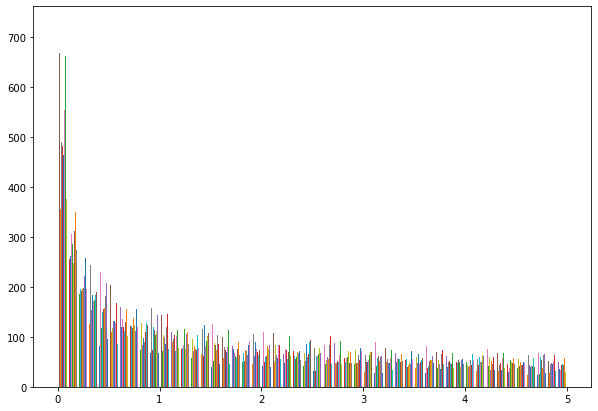

In [53]:
plt.figure(figsize=[10,7])
plt.hist(chisq,bins=50,range=[0,5])

In [244]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})


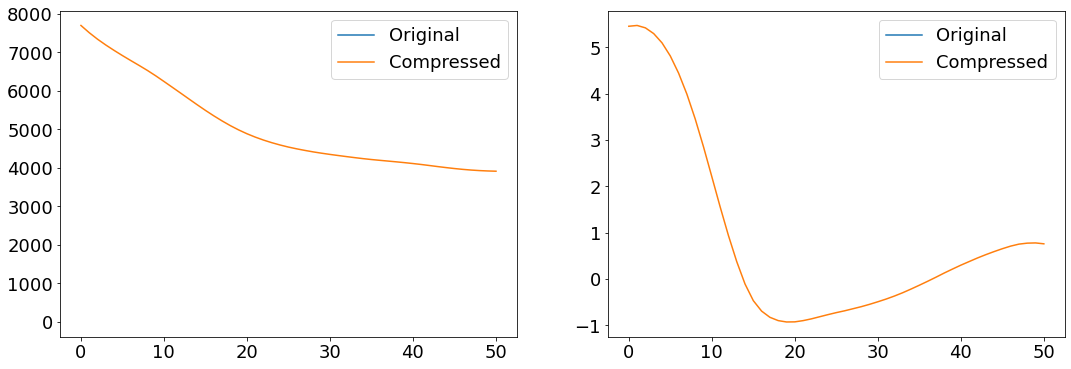

In [238]:
# Example plots 

i = 146
plt.figure(figsize=[18,6])
plt.subplot(121)
plt.plot(data[i,0], label = 'Original')
plt.plot(data_reconstructed[i,0], label = 'Compressed')
plt.legend()

plt.subplot(122)
plt.plot(data[i,1]/1E5, label = 'Original')
plt.plot(data_reconstructed[i,1]/1E5, label = 'Compressed')
plt.legend()

### Simple validation here:

In [208]:
ae_model = torch.load('hinode_encoding_atmos_6.pt')

In [209]:
data_val = fits.open("C:/Data/Hinode_ML_compression/qs_ph_disk_center_1_1_tau.fits")[0].data

In [210]:
data_val = data_val.transpose(0,2,3,1)
data_val = data_val.reshape(-1,768*768,71)

In [211]:
data_val.shape

(11, 589824, 71)

In [212]:
#data_val /= np.mean(data_val[:,:10])

In [213]:
#data_val += np.random.normal(0,2E-3, (768*768, 112))
data_val = data_val[[1,5],:,5:-15]
data_val.shape

(2, 589824, 51)

In [214]:
print (dmin, max)

[    2684.79135309 -1448807.5302869 ] <built-in function max>


In [215]:
data_val = (data_val - dmin[:,None,None]) / (dmax[:,None,None] - dmin[:, None, None])

In [216]:
data_val = data_val.transpose(1,0,2)
data_val = data_val.reshape(-1,102)

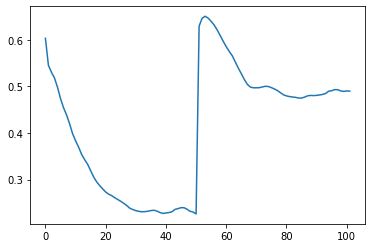

In [217]:
plt.plot(data_val[151])

In [218]:
data_val = torch.from_numpy(data_val.astype('float32'))

In [219]:
data_val_predicted = model_predict(ae_model,data_val, cudaoption)
data_val_compressed = model_encode(ae_model,data_val, cudaoption)

In [220]:
data_val_predicted = data_val_predicted.detach().numpy()
data_val = data_val.detach().numpy()

In [221]:
data_val_predicted = data_val_predicted.reshape(-1,2,51)
data_val = data_val.reshape(-1,2,51)

In [222]:
data_val_predicted = data_val_predicted * (dmax[None,:,None]-dmin[None,:,None]) + dmin[None,:, None]
data_val = data_val * (dmax[None,:,None]-dmin[None,:,None]) + dmin[None,:, None]

In [165]:
#noise = np.mean(data[:,0]) * 1E-2

#residual = (data_val - data_val_predicted)
#residual /= noise
#residual = residual**2.0
#print (len(residual))
#chisq = np.sum(residual,axis=1) / 112
#print (np.mean(chisq))
#print (np.median(chisq))

In [228]:
tau = fits.open("C:/Data/Hinode_ML_compression/qs_ph_disk_center_1_1_tau.fits")[0].data[0,:,0,0]

In [246]:
matplotlib.rcParams.update({'font.size': 20})

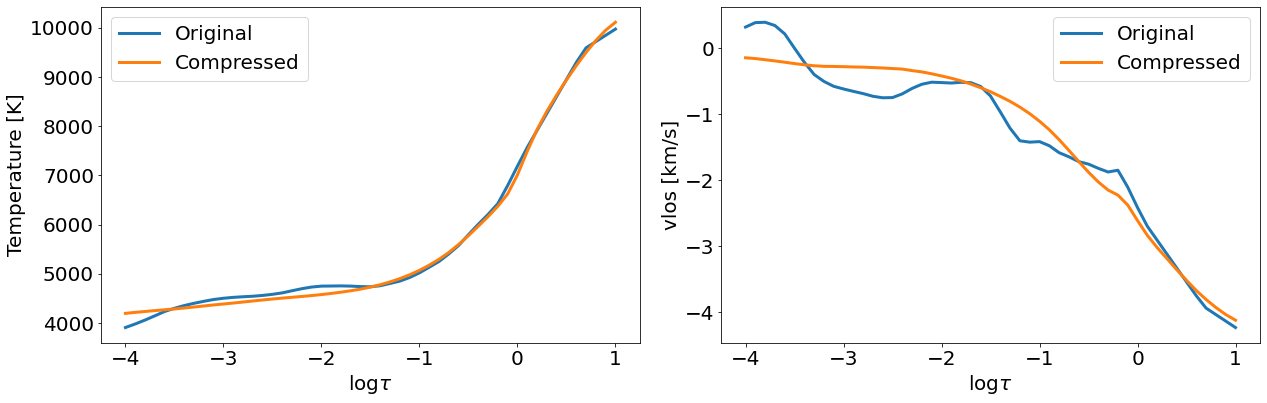

In [247]:
# Example plots 
i = 11551
plt.figure(figsize=[18,6])
plt.subplot(121)
plt.plot(tau[5:-15], data_val[i,0], label = 'Original', lw = 3)
plt.plot(tau[5:-15], data_val_predicted[i,0], label = 'Compressed', lw = 3)
plt.xlabel("$\log \\tau$")
plt.ylabel("Temperature [K]")
plt.legend()

plt.subplot(122)
plt.plot(tau[5:-15], data_val[i,1]/1E5, label = 'Original', lw = 3)
plt.plot(tau[5:-15], data_val_predicted[i,1]/1E5, label = 'Compressed', lw = 3)
plt.xlabel("$\log \\tau$")
plt.ylabel("vlos [km/s]")

plt.legend()
plt.tight_layout()
plt.savefig("atmos_compression.png",bbox_inches='tight')

In [224]:
data_val_compressed = data_val_compressed.detach().numpy()

In [225]:
data_val_compressed = data_val_compressed.reshape(768,768,6)

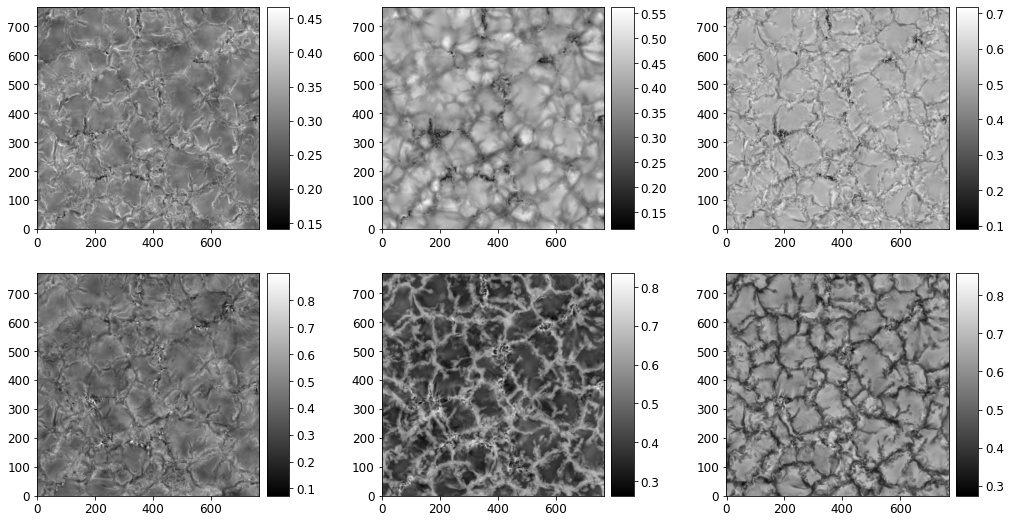

In [251]:
matplotlib.rcParams.update({'font.size': 12})

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(2, 3, figsize=[17.5,9])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].imshow(data_val_compressed[:,:,i].T,  cmap = 'gray', origin = 'lower')
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='10%', pad=0.1)

    fig.colorbar(im, cax=cax, orientation='vertical')
    
fig.savefig("atmos_maps.png",bbox_inches='tight')

IndexError: index 4 is out of bounds for axis 2 with size 4

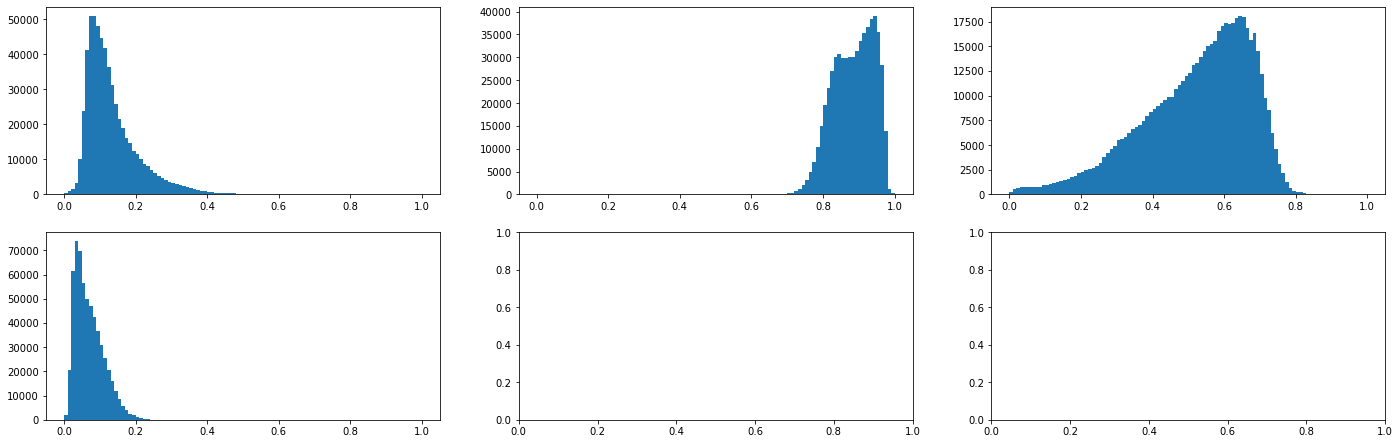

In [132]:
fig, axes = plt.subplots(2, 3, figsize=[24.0,7.6])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].hist(data_val_compressed[:,:,i].flatten(),bins=100,range=(0,1))
    
    #divider = make_axes_locatable(axes[i])
    #cax = divider.append_axes('right', size='10%', pad=0.1)

    #fig.colorbar(im, cax=cax, orientation='vertical')

## Here we apply it to the Lites cube!

In [ ]:
obs_qs = fits.open("C:/Data/Hinode_ML_compression/lites_qs.fits")[0].data[:,:,0,:]

In [ ]:
obs_qs = obs_qs.astype('double')

In [ ]:
mean_qs = np.mean(obs_qs, axis=(0,1))

In [ ]:
obs_qs.shape

In [ ]:
plt.plot(obs_qs[0,0])

In [ ]:
plt.plot(mean_qs)

In [ ]:
qs_cont = np.mean(mean_qs[-10:])

In [ ]:
obs_qs[:,:,:] = obs_qs / qs_cont

In [ ]:
plt.plot(obs_qs[0,0])

In [ ]:
obs_qs = obs_qs.reshape(-1,112)

In [ ]:
obs_qs.shape

In [ ]:
obs_qs = (obs_qs - dmin) / (dmax-dmin)
obs_qs = torch.from_numpy(obs_qs.astype('float32'))
obs_qs_predicted = model_predict(ae_model,obs_qs, cudaoption)
obs_qs_predicted = obs_qs_predicted.detach().numpy()
obs_qs = obs_qs.detach().numpy()
obs_qs_predicted = obs_qs_predicted * (dmax-dmin) + dmin
obs_qs = obs_qs * (dmax-dmin) + dmin
noise = np.mean(data[:,0]) * 7E-3

residual = (obs_qs - obs_qs_predicted)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 112
print (np.mean(chisq))
print (np.median(chisq))

In [ ]:
plt.figure(figsize=[10,7])
plt.hist(chisq.flatten(),bins=50,range=[0,10])

In [ ]:
obs_qs = torch.from_numpy(obs_qs.astype('float32'))


In [ ]:
obs_qs_compressed = model_encode(ae_model,obs_qs, cudaoption)
obs_qs_compressed = obs_qs_compressed.detach().numpy()
obs_qs_compressed = obs_qs_compressed.reshape(1024,2047,6)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=[15.0,9])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].imshow(obs_qs_compressed[:512,:512,i])
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='10%', pad=0.1)

    fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=[24.0,7.6])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].hist(obs_qs_compressed[:,:,i].flatten(),bins=100,range=(0,1))
    
    #divider = make_axes_locatable(axes[i])
    #cax = divider.append_axes('right', size='10%', pad=0.1)

    #fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
i = 86681

plt.figure(figsize=[10,6])
plt.plot(obs_qs[i],label='original')
plt.plot(obs_qs_predicted[i], label = 'compressed')
plt.legend()

## How does it compare with PCA?

In [ ]:
import numpy as np
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=6, batch_size=512)
ipca.fit(data_val.reshape(-1,112))


In [ ]:
data_val_ipca = ipca.transform(data_val.reshape(-1,112))

In [ ]:
data_val_ipca.shape

In [ ]:
data_val_restored = ipca.inverse_transform(data_val_ipca)


In [ ]:
data_val = data_val.detach().numpy()

In [ ]:
residual = (data_val - data_val_restored)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 112
print (np.mean(chisq))
print (np.median(chisq))

In [ ]:
data_val_ipca = data_val_ipca.reshape(768,768,6)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(2, 3, figsize=[17.5,9])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].imshow(data_val_ipca[:,:,i])
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='10%', pad=0.1)

    fig.colorbar(im, cax=cax, orientation='vertical')